In [ ]:
!nvidia-smi

Mon Jan 25 19:19:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Parameters

BATCH_SIZE = 128
MAX_SEQ_LENGTH = 512
NUM_CLASSES = 5
NUM_SAMPLES = 10

In [ ]:
# Installs

!pip install datasets --quiet
!pip install torch torchvision --quiet
!pip install pytorch_transformers --quiet

!pip install nlp --quiet
!pip install transformers --quiet

     |████████████████████████████████| 163kB 7.7MB/s 
     |████████████████████████████████| 20.7MB 1.3MB/s 
     |████████████████████████████████| 245kB 42.9MB/s 
     |████████████████████████████████| 184kB 9.1MB/s 
     |████████████████████████████████| 1.2MB 13.7MB/s 
     |████████████████████████████████| 890kB 29.8MB/s 
     |████████████████████████████████| 133kB 37.1MB/s 
     |████████████████████████████████| 7.2MB 37.0MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
ERROR: botocore 1.19.60 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 1.7MB 8.9MB/s 
     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 2.9MB 39.6MB/s 


In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from datasets import load_dataset
from pytorch_transformers import BertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

In [ ]:
# Load dataset. For now, `review_title` + review_body` is X, and `stars` is y.

dataset = load_dataset('amazon_reviews_multi', 'en')

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/f3357bd271e187385a38574fe31b8fb10055303f67fa9fce55e84d08c4870efd. Subsequent calls will reuse this data.


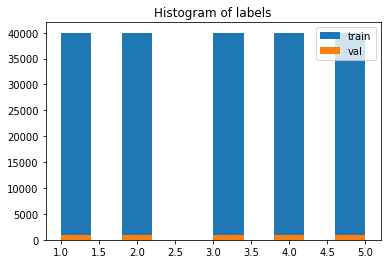

In [ ]:
# Plot histogram of labels. Looks like classes are balanced (not really going to happen in the "real world," FYI)

train_labels = np.array([elem['stars'] for elem in dataset['train']])
val_labels = np.array([elem['stars'] for elem in dataset['validation']])
plt.hist(train_labels, label='train')
plt.hist(val_labels, label='val')
plt.title('Histogram of labels')
plt.legend()
plt.show()

In [ ]:
# Inspect a few elements. What do they look like?

samples = np.random.permutation(len(dataset['train']))[:NUM_SAMPLES]
for idx in samples:
  sample = dataset['train'][int(idx)]
  print(sample)

# TODO: How do we look at just the review title + body and label.

{'language': 'en', 'product_category': 'home', 'product_id': 'product_en_0705759', 'review_body': 'I love the Advent candle holder. It is beautiful and well made. The pillar advent candles are lovely. I placed a large glass ball on the center and a large white candle will look great too as a choice.', 'review_id': 'en_0625291', 'review_title': 'Sturdy and lovely candle holder for Advent.', 'reviewer_id': 'reviewer_en_0374700', 'stars': 5}
{'language': 'en', 'product_category': 'pet_products', 'product_id': 'product_en_0402537', 'review_body': 'This product gave my dog diarrhea for a week.', 'review_id': 'en_0269474', 'review_title': 'Buyer Beware', 'reviewer_id': 'reviewer_en_0151244', 'stars': 1}
{'language': 'en', 'product_category': 'toy', 'product_id': 'product_en_0932166', 'review_body': 'Not as easy to mold and the instructions were not clear. Use terms to describe that were not mentioned anywhere else so you had to guess and trial and error. Once you figure that out - they look 

In [ ]:
# Helpers

SEP_TOKEN = '[SEP]'
CLS_TOKEN = '[CLS]'

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Dataset class where every element is (x, y) where x is a tokenized list of words and y is the label.
class TextDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.original_dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        original_data = self.original_dataset[index]
        text = str(original_data['review_title'] + original_data['review_body'])
        label = int(original_data['stars']) - 1

        # Tokenize text, convert to ids
        tokens = self.tokenizer.tokenize(text)
        tokens = [CLS_TOKEN] + tokens + [SEP_TOKEN]
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = input_ids[:MAX_SEQ_LENGTH]

        padding_length = MAX_SEQ_LENGTH - len(input_ids)
        # segment_ids = [0] * len(input_ids)
        input_length = len(input_ids)
        input_ids = input_ids + [0] * padding_length
        # segment_ids = segment_ids + [0] * padding_length

        # assert len(input_ids) == MAX_SEQ_LENGTH
        # assert len(input_mask) == MAX_SEQ_LENGTH
        # assert len(segment_ids) == MAX_SEQ_LENGTH

        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(input_length, dtype=torch.long), torch.tensor(label, dtype=torch.long)

        # return torch.tensor(input_ids, dtype=torch.long), \
        #        torch.tensor(segment_ids, dtype=torch.long), \
        #        torch.tensor(input_mask), \
        #        torch.tensor(label, dtype=torch.long)

In [ ]:
# Build a model in PyTorch. We are training a classification model. We will use the BERT architecture.
# Modified https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
# Architecture inspired by http://jalammar.github.io/illustrated-bert/.

class PyTorchBERT(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, num_classes, dropout=0.5):
        super(PyTorchBERT, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.final_layer = nn.Linear(ninp, num_classes)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.final_layer.bias.data.zero_()
        self.final_layer.weight.data.uniform_(-initrange, initrange)

    # TODO: use inp_length in the code
    def forward(self, src, src_mask, inp_length):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)

        # Get an embedding for each example in the batch
        output = output.max(1)[0] # batch size x 1
        
        return F.log_softmax(self.final_layer(output), dim=1)

In [ ]:
# Preprocess data

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TextDataset(dataset['train'], tokenizer)
val_dataset = TextDataset(dataset['validation'], tokenizer)
test_dataset = TextDataset(dataset['test'], tokenizer)

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 231508/231508 [00:00<00:00, 898823.25B/s]


In [ ]:
# TODO: Inspect an element of the preprocessed dataset

In [ ]:
# Create training and evaluator loops

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
ntokens = len(tokenizer)
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = PyTorchBERT(ntokens, emsize, nhead, nhid, nlayers, NUM_CLASSES, dropout).to(device)

criterion = nn.NLLLoss()
lr = 1e-4 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Had SGD before and it was shit
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train(dataloader):
    model.train() # Turn on the train mode
    total_loss = 0.
    num_correct = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(MAX_SEQ_LENGTH).to(device)
    for idx, batch in enumerate(dataloader):
        data, inp_length, targets = batch
        optimizer.zero_grad()
        if data.size(0) != MAX_SEQ_LENGTH:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data.to(device), src_mask, inp_length)
        loss = criterion(output, targets.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) #tutorial does this
        optimizer.step()

        num_correct += torch.sum(torch.argmax(output, dim=1) == targets.to(device))

        total_loss += loss.item()
        log_interval = 200
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            batch_acc = num_correct / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | batch acc {:5.2f}'.format(
                    epoch, idx, len(train_dl), scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, batch_acc))
            total_loss = 0
            num_correct = 0
            start_time = time.time()

def evaluate(eval_model, dataloader):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    num_correct = 0.
    src_mask = model.generate_square_subsequent_mask(MAX_SEQ_LENGTH).to(device)
    with torch.no_grad():
        for batch in dataloader:
            data, inp_length, targets = batch
            if data.size(0) != MAX_SEQ_LENGTH:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data.to(device), src_mask, inp_length)
            num_correct += torch.sum(torch.argmax(output, dim=1) == targets.to(device))
            total_loss += len(data) * criterion(output, targets.to(device)).item()
    return total_loss / len(dataloader), num_correct

In [ ]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_dl)
    val_loss, val_num_correct = evaluate(model, val_dl)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} '.format(epoch, (time.time() - epoch_start_time),
                                     val_loss))
    print(f'val acc: {val_num_correct / len(val_dataset)}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (760 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |   200/ 1563 batches | lr 0.00 | ms/batch 196.50 | loss  1.59 | batch acc 35.58


Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (685 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (858 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   1 |   400/ 1563 batches | lr 0.00 | ms/batch 195.88 | loss  1.40 | batch acc 52.56


Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (708 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   1 |   600/ 1563 batches | lr 0.00 | ms/batch 195.61 | loss  1.27 | batch acc 60.11


Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (794 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   1 |   800/ 1563 batches | lr 0.00 | ms/batch 195.83 | loss  1.19 | batch acc 63.53


Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (641 > 512). Running this sequence through the model will result in indexing errors


| epoch   1 |  1000/ 1563 batches | lr 0.00 | ms/batch 195.57 | loss  1.13 | batch acc 66.92


Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (691 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   1 |  1200/ 1563 batches | lr 0.00 | ms/batch 196.52 | loss  1.09 | batch acc 68.00


Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (698 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   1 |  1400/ 1563 batches | lr 0.00 | ms/batch 198.18 | loss  1.08 | batch acc 68.25


Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (680 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 311.50s | valid loss 123.75 
val acc: 0.5709999799728394
-----------------------------------------------------------------------------------------


Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors


| epoch   2 |   200/ 1563 batches | lr 0.00 | ms/batch 196.03 | loss  1.03 | batch acc 71.58


Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (641 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   2 |   400/ 1563 batches | lr 0.00 | ms/batch 195.66 | loss  1.02 | batch acc 72.28


Token indices sequence length is longer than the specified maximum sequence length for this model (698 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (858 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   2 |   600/ 1563 batches | lr 0.00 | ms/batch 195.96 | loss  1.01 | batch acc 72.99


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (685 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors


| epoch   2 |   800/ 1563 batches | lr 0.00 | ms/batch 195.49 | loss  0.99 | batch acc 73.15


Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (708 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (664 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   2 |  1000/ 1563 batches | lr 0.00 | ms/batch 197.12 | loss  1.00 | batch acc 72.55


Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


| epoch   2 |  1200/ 1563 batches | lr 0.00 | ms/batch 196.63 | loss  1.00 | batch acc 72.77


Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   2 |  1400/ 1563 batches | lr 0.00 | ms/batch 197.80 | loss  0.99 | batch acc 72.75


Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (760 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 311.90s | valid loss 120.02 
val acc: 0.5823999643325806
-----------------------------------------------------------------------------------------


Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (760 > 512). Running this sequence through the model will result in indexing errors


| epoch   3 |   200/ 1563 batches | lr 0.00 | ms/batch 197.75 | loss  0.97 | batch acc 74.79


Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (858 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (680 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors


| epoch   3 |   400/ 1563 batches | lr 0.00 | ms/batch 196.95 | loss  0.96 | batch acc 75.12


Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   3 |   600/ 1563 batches | lr 0.00 | ms/batch 196.86 | loss  0.96 | batch acc 74.40


Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors


| epoch   3 |   800/ 1563 batches | lr 0.00 | ms/batch 195.59 | loss  0.96 | batch acc 74.72


Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (685 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   3 |  1000/ 1563 batches | lr 0.00 | ms/batch 196.30 | loss  0.95 | batch acc 75.61


Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (708 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   3 |  1200/ 1563 batches | lr 0.00 | ms/batch 196.15 | loss  0.95 | batch acc 75.49


Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

| epoch   3 |  1400/ 1563 batches | lr 0.00 | ms/batch 198.38 | loss  0.96 | batch acc 75.95


Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 312.26s | valid loss 118.74 
val acc: 0.5857999920845032
-----------------------------------------------------------------------------------------


In [ ]:
# Hugging Face finetuning

hf_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=NUM_CLASSES)
hf_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    res = hf_tokenizer(batch['review_title'], batch['review_body'], padding=True, truncation=True)
    res['labels'] = [elem - 1 for elem in batch['stars']]
    return res
    # return {'attention_mask': res['attention_mask'], 'input_ids': res['input_ids'], 'labels': res['labels']}

hf_train_dataset = dataset['train'].map(tokenize, batched=True, batch_size=BATCH_SIZE)
hf_val_dataset = dataset['validation'].map(tokenize, batched=True, batch_size=BATCH_SIZE)
hf_test_dataset = dataset['test'].map(tokenize, batched=True, batch_size=BATCH_SIZE)

hf_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
hf_val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
hf_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    evaluation_strategy = "epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs'
)

trainer = Trainer(
    model=hf_model,
    args=training_args,
    compute_metrics=compute_metrics,
    tokenizer=hf_tokenizer,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
